In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

In [2]:
GT=np.load('AuxData/Ti7FFT.npy')
# row content
# 0  dilation
# 1  E11
# 2  E12
# 3  E13
# 4  E22
# 5  E23
# 6  E33
# 7  Grain ID
# 8  Phi1
# 9  Psi
# 10 Phi2

In [24]:
orig=[-0.256,-0.256]
step=[0.002,0.002]
gid=40

GIDLayer=GT[7].astype(int)
tmpx=np.arange(orig[0],step[0]*GIDLayer.shape[0]+orig[0],step[0])
tmpy=np.arange(orig[1],step[1]*GIDLayer.shape[1]+orig[1],step[1])
xv,yv=np.meshgrid(tmpx,tmpy)
idx=np.where(GIDLayer==gid)
x=xv[idx]
y=yv[idx]

In [38]:
tmpDil=GT[0][idx]*40
tmpE11=GT[1][idx]*40
tmpE12=GT[2][idx]*40
tmpE13=GT[3][idx]*40
tmpE22=GT[4][idx]*40
tmpE23=GT[5][idx]*40
tmpE33=GT[6][idx]*40
# This is wrong, the strain of lattice parameters and inverse lattice parameters (Gs) are
# different, see the Transform2RealS function. S^(-T)O=PU. And I also assume orientations are
# the same as averaged orientation: O=U. I'm just lazy, I will correct it later.
ss=np.zeros((len(x),3,3))
ss[:,0,0]=tmpE11+1
ss[:,0,1]=tmpE12
ss[:,0,2]=tmpE13
ss[:,1,0]=ss[:,0,1]
ss[:,2,0]=ss[:,0,2]
ss[:,1,1]=tmpE22+1
ss[:,1,2]=tmpE23
ss[:,2,1]=ss[:,1,2]
ss[:,2,2]=tmpE33+1

<IPython.core.display.Javascript object>


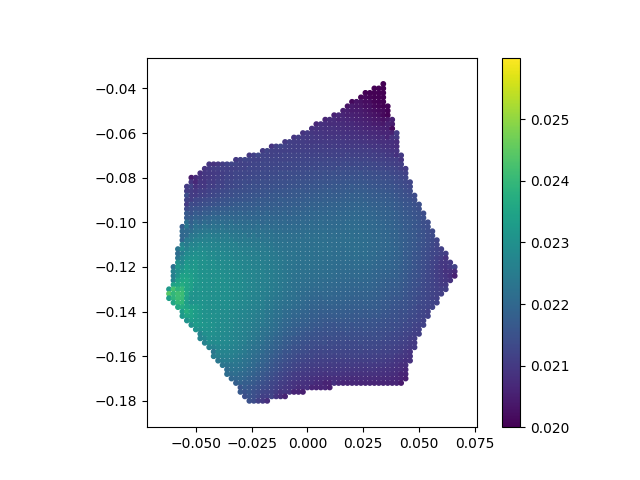

In [40]:
plt.scatter(x,-y,c=ss[:,2,2]-1,s=10
            ,vmin=0.02,vmax=0.026
           )
plt.axis('scaled')
plt.colorbar()
plt.show()

In [19]:
a=h5py.File('../SimData/grain_40_fac40.hdf5','r')

tmp=np.array(a['Imgs']['Im2'])
print(np.max(tmp))
np.where(tmp==np.max(tmp))

<IPython.core.display.Javascript object>


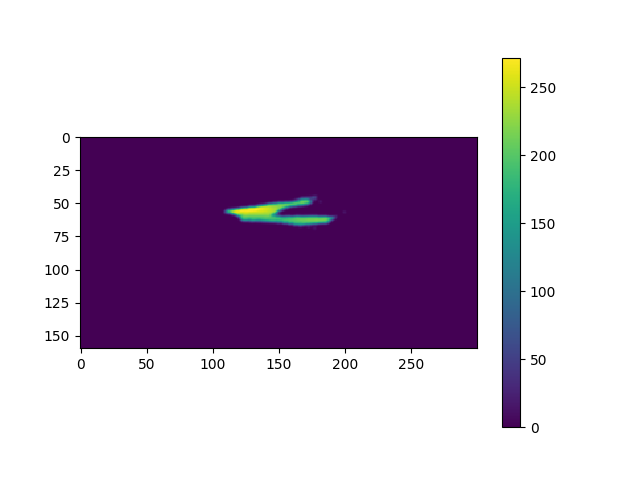

In [81]:
%matplotlib notebook
plt.imshow(a['Imgs']['Im2'][:,:,13])
plt.colorbar()
plt.show()

In [58]:
b=h5py.File('../SimData/grain_40_sca1_fac40.hdf5','r')

tmp=np.array(b['Imgs']['Im2'])
print(np.max(tmp))
np.where(tmp==np.max(tmp))

2


(array([51, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 54, 54, 54, 54, 54,
        54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 55, 55, 55, 55, 55, 55,
        55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 56,
        56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56,
        56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 57, 57, 57, 57, 57, 57, 57,
        57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58,
        58, 58, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 60,
        60, 60, 60, 60, 60]),
 array([133, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 133,
        134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146,
        147, 148, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135,
        136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 117, 118,
        119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 13

<IPython.core.display.Javascript object>


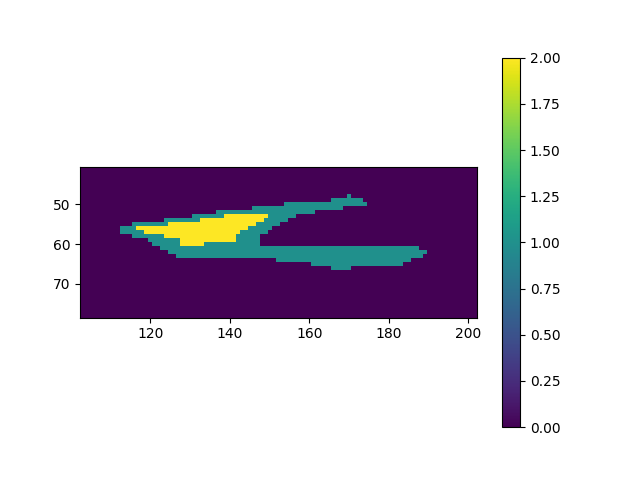

In [60]:
%matplotlib notebook
plt.imshow(b['Imgs']['Im2'][:,:,13])
plt.colorbar()
plt.show()

In [41]:
import pycuda.gpuarray as gpuarray
from pycuda.autoinit import context
import pycuda.driver as cuda
import pycuda.autoinit
import numpy as np
dev=cuda.Device(2)
dev.make_context()

import util.RotRep as Rot
from InitStrain import Initializer
from Reconst_GPU import StrainReconstructor_GPU
Cfg=Initializer('ConfigFiles/g40.yml')
peakFile=h5py.File('../SimData/grain_40_fac40.hdf5','r')
Cfg.SetPosOrien(peakFile['Pos'],peakFile['Orien'])
Cfg.Simulate()
recon=StrainReconstructor_GPU( _NumG=Cfg.NumG,
        peakFile=peakFile,
        _Det=Cfg.Det, _Gs=Cfg.Gs, _Info=Cfg.Info, _eng=Cfg.eng)
recon.loadGs()
recon.loadIm()

NumD=len(x)

SD=gpuarray.to_gpu(ss.ravel().astype(np.float32))

XD=gpuarray.empty(Cfg.NumG*NumD,dtype=np.int32)
YD=gpuarray.empty(Cfg.NumG*NumD,dtype=np.int32)
OffsetD=gpuarray.empty(Cfg.NumG*NumD,dtype=np.int32)

MaskD=gpuarray.empty(Cfg.NumG*NumD,dtype=np.bool_)
TrueMaskD=gpuarray.empty(Cfg.NumG*NumD,dtype=np.bool_)

xD=gpuarray.to_gpu(x.astype(np.float32))
yD=gpuarray.to_gpu(y.astype(np.float32))

BlockSize=256
scoreD=gpuarray.empty(NumD,dtype=np.float32)
recon.sim_grain(XD,YD,OffsetD,MaskD,TrueMaskD,
                    xD, yD,recon.afDetInfoD,SD,
                    recon.whichOmegaD,np.int32(NumD),np.int32(Cfg.NumG),np.float32(recon.eng),np.int32(45),recon.LimD,np.int32(5),
                     block=(recon.NumG,1,1),grid=(NumD,1))
recon.hit_func(scoreD,
                XD,YD,OffsetD,MaskD,TrueMaskD,
                recon.MaxIntD,np.int32(recon.NumG),np.int32(NumD),np.int32(45),
                block=(BlockSize,1,1),grid=(int(NumD/BlockSize+1),1))
scoreH=scoreD.get()

<IPython.core.display.Javascript object>


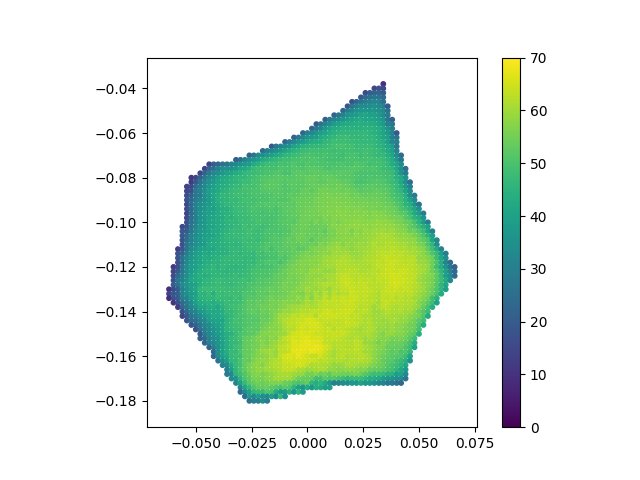

In [43]:
plt.scatter(x,-y,c=scoreH,s=10
            ,vmin=0,vmax=70
           )
plt.axis('scaled')
plt.colorbar()

plt.show()

In [44]:
# x40=np.load('/home/yufengs/SimData/g40_fac40/x.npy')
# y40=np.load('/home/yufengs/SimData/g40_fac40/y.npy')
S40=np.load('/home/yufengs/SimData/g40_fac40/allMaxS.npy')
c40=np.load('/home/yufengs/SimData/g40_fac40/allMaxScore.npy')

<IPython.core.display.Javascript object>


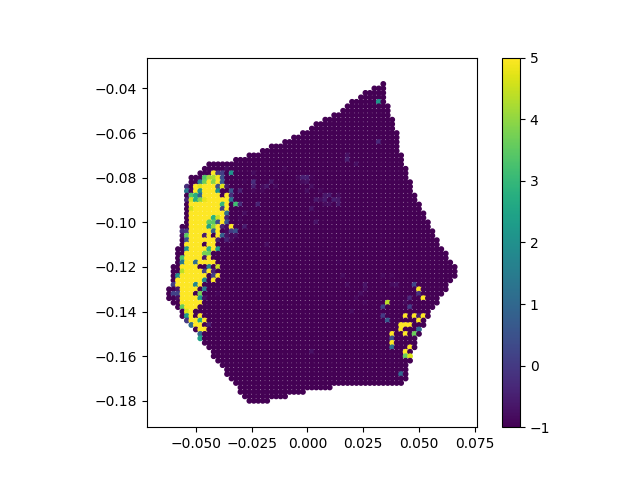

In [57]:
plt.scatter(x,-y,c=scoreH-c40,s=10
            ,vmin=-1,vmax=5
           )
plt.axis('scaled')
plt.colorbar()

plt.show()

<IPython.core.display.Javascript object>


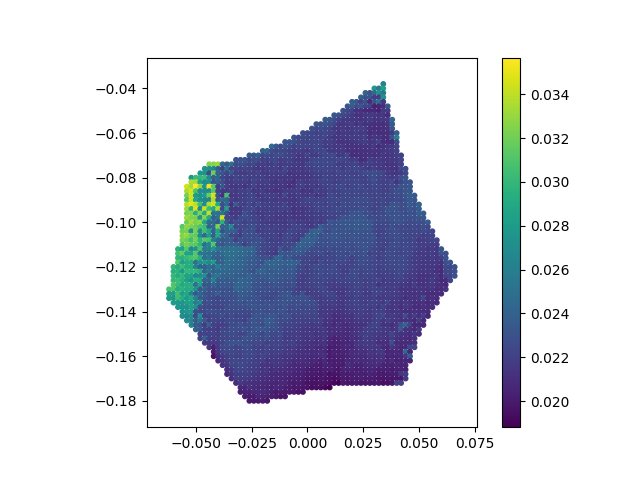

In [52]:
plt.scatter(x,-y,c=S40[:,2,2]-1,s=10
#             ,vmin=0.02,vmax=0.026
           )
plt.axis('scaled')
plt.colorbar()
plt.show()

In [71]:
np.sum(a['Imgs']['Im2'])/np.sum(b['Imgs']['Im2'])

254.99068585944116

In [72]:
np.sum(a['Imgs']['Im3'])/np.sum(b['Imgs']['Im3'])

240.45810055865923

In [74]:
b['Imgs']['Im2'][:,:,13]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)